## **Image Caption Generator**

# Introduction

* Image captioning is the task of generating textual descriptions of a given image, requiring techniques of computer vision and natural language processing.
* Generating well-formed sentences requires both syntactic and semantic understanding of the language. Being able to describe the content of an image using accurately formed sentences is a very challenging task, but it could also have a great impact, by helping visually impaired people better understand the content of images.





* Dataset : https://cocodataset.org/#download
* Here, I have used COCO Dataset 2017 which contains 12 different types of categories and among them it has 80 types of sub-categories.
* Each sub categories contain list of images and five captions to each image.



# Importing all library

In [ ]:
import numpy as np
import pandas as pd

# For visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# COCO Python library
from pycocotools.coco import COCO

import random 
import string
import os
import json
import skimage.io as io

# For Preprocessing the data
from tensorflow.keras.preprocessing.text import Tokenizer

# For extracting the feature from image
from tensorflow.keras.applications.xception import Xception, preprocess_input

import cv2

# Small library for seeing the progress of loops.
from tqdm.notebook import tqdm

# For training Library
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Dropout, Attention
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

from keras.layers.merge import add


# Exploring Dataset

* Initialize COCO class and operate instances_train data.

In [ ]:
coco = COCO("/content/drive/MyDrive/annotations_trainval2017/annotations/instances_train2017.json")

loading annotations into memory...
Done (t=18.51s)
creating index...
index created!


* loadCats() - Load categories with the specified ids

In [ ]:
categories = coco.loadCats(coco.getCatIds())
print(categories[:5]) 

[{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}, {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}, {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}]


## Find Main Categories


In [ ]:
main_categories = list(set([category['supercategory'] for category in categories]))

In [ ]:
# length of main categories
print("Number of main categories: ", len(main_categories))
print("List of main categories: ", main_categories)

Number of main categories:  12
List of main categories:  ['food', 'outdoor', 'furniture', 'accessory', 'animal', 'appliance', 'indoor', 'electronic', 'sports', 'kitchen', 'person', 'vehicle']


## Find Sub Categories 

In [ ]:
sub_categories = [category['name'] for category in categories]

In [ ]:
# length of sub categories
print("Number of sub categories: ", len(sub_categories))
print("List of sub categories: ", sub_categories)

Number of sub categories:  80
List of sub categories:  ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


## Find Sub Categories with their corresponding Unique IDs

* getCatIds() - Get category ids that satisfy given filter conditions.

In [ ]:
category_IDs = coco.getCatIds(catNms=sub_categories) 

In [ ]:
# category_IDs

In [ ]:
sub_categories_IDs = dict()
for i in range(0, len(sub_categories)):
    sub_categories_IDs[sub_categories[i]] = category_IDs[i]

print("Sub Categories with Unique IDs: ", sub_categories_IDs)

Sub Categories with Unique IDs:  {'person': 1, 'bicycle': 2, 'car': 3, 'motorcycle': 4, 'airplane': 5, 'bus': 6, 'train': 7, 'truck': 8, 'boat': 9, 'traffic light': 10, 'fire hydrant': 11, 'stop sign': 13, 'parking meter': 14, 'bench': 15, 'bird': 16, 'cat': 17, 'dog': 18, 'horse': 19, 'sheep': 20, 'cow': 21, 'elephant': 22, 'bear': 23, 'zebra': 24, 'giraffe': 25, 'backpack': 27, 'umbrella': 28, 'handbag': 31, 'tie': 32, 'suitcase': 33, 'frisbee': 34, 'skis': 35, 'snowboard': 36, 'sports ball': 37, 'kite': 38, 'baseball bat': 39, 'baseball glove': 40, 'skateboard': 41, 'surfboard': 42, 'tennis racket': 43, 'bottle': 44, 'wine glass': 46, 'cup': 47, 'fork': 48, 'knife': 49, 'spoon': 50, 'bowl': 51, 'banana': 52, 'apple': 53, 'sandwich': 54, 'orange': 55, 'broccoli': 56, 'carrot': 57, 'hot dog': 58, 'pizza': 59, 'donut': 60, 'cake': 61, 'chair': 62, 'couch': 63, 'potted plant': 64, 'bed': 65, 'dining table': 67, 'toilet': 70, 'tv': 72, 'laptop': 73, 'mouse': 74, 'remote': 75, 'keyboard':

## Find total images with each Sub Categories

* getImgIds() - Get image ids that satisfy given filter conditions.

In [ ]:
# create a dictionary that contains sub category with their image ids
total_image_subcat = dict()

for i in range(0, len(category_IDs)):
    image_Ids = coco.getImgIds(catIds=category_IDs[i])
    image = []

    for j in image_Ids:
        image.append(j)
    
    total_image_subcat[sub_categories[i]] = image

print("total Sub categories with Image IDs: ", len(total_image_subcat))

total Sub categories with Image IDs:  80


In [ ]:
# create a dictionary containing sub category with their total images
image_dict = {key: len(value) for key, value in total_image_subcat.items()}
print("Total images in each sub categories: ", image_dict)

Total images in each sub categories:  {'person': 64115, 'bicycle': 3252, 'car': 12251, 'motorcycle': 3502, 'airplane': 2986, 'bus': 3952, 'train': 3588, 'truck': 6127, 'boat': 3025, 'traffic light': 4139, 'fire hydrant': 1711, 'stop sign': 1734, 'parking meter': 705, 'bench': 5570, 'bird': 3237, 'cat': 4114, 'dog': 4385, 'horse': 2941, 'sheep': 1529, 'cow': 1968, 'elephant': 2143, 'bear': 960, 'zebra': 1916, 'giraffe': 2546, 'backpack': 5528, 'umbrella': 3968, 'handbag': 6841, 'tie': 3810, 'suitcase': 2402, 'frisbee': 2184, 'skis': 3082, 'snowboard': 1654, 'sports ball': 4262, 'kite': 2261, 'baseball bat': 2506, 'baseball glove': 2629, 'skateboard': 3476, 'surfboard': 3486, 'tennis racket': 3394, 'bottle': 8501, 'wine glass': 2533, 'cup': 9189, 'fork': 3555, 'knife': 4326, 'spoon': 3529, 'bowl': 7111, 'banana': 2243, 'apple': 1586, 'sandwich': 2365, 'orange': 1699, 'broccoli': 1939, 'carrot': 1683, 'hot dog': 1222, 'pizza': 3166, 'donut': 1523, 'cake': 2925, 'chair': 12774, 'couch': 44

In [ ]:
# sort the image dictionary
sorted_image_dict = sorted(image_dict.items(), key = lambda x: x[1], reverse=True)
sorted_image_dict[-60:-40]

[('sports ball', 4262),
 ('traffic light', 4139),
 ('cat', 4114),
 ('umbrella', 3968),
 ('bus', 3952),
 ('tie', 3810),
 ('bed', 3682),
 ('vase', 3593),
 ('train', 3588),
 ('fork', 3555),
 ('spoon', 3529),
 ('laptop', 3524),
 ('motorcycle', 3502),
 ('surfboard', 3486),
 ('skateboard', 3476),
 ('tennis racket', 3394),
 ('toilet', 3353),
 ('bicycle', 3252),
 ('bird', 3237),
 ('pizza', 3166)]

In [ ]:
total_image_subcat['bus'][-10:]

[147418, 131044, 491492, 106471, 327656, 294892, 114673, 24566, 122871, 466942]

In [ ]:
total_image_subcat['laptop'][:10]

[196608,
 106497,
 196611,
 131075,
 294920,
 344073,
 417802,
 213003,
 557067,
 262162]

* Here, I have selected  two sub categories Bus and Laptop for accomplishing image caption generator.



In [ ]:
train_categories = total_image_subcat['bus'] + total_image_subcat['laptop']

# Get image ids that having image ids from train_categories
image_Id = coco.getImgIds(imgIds=train_categories)
print("Total Images: ", len(image_Id))

Total Images:  7470


## Load some random images

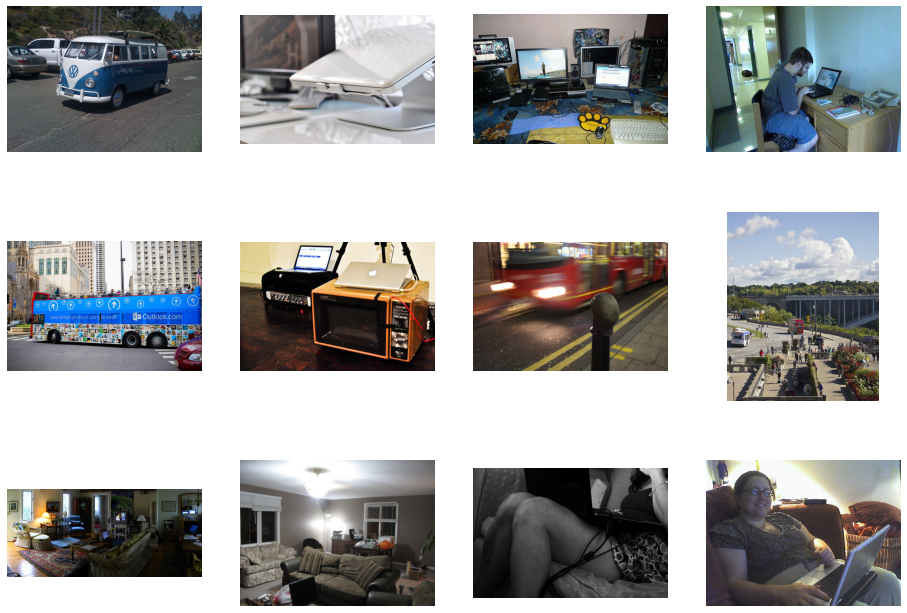

In [ ]:
fig = plt.figure(figsize=(16, 16))

next_image = image_Id
random.shuffle(next_image)

for i, image_path in enumerate(next_image[0:12]):
    plot = plt.subplot(4, 4, i+1)
    plot.axis('Off')

    img_dict = coco.loadImgs(image_path)[0]
    img = io.imread(img_dict['coco_url'])
    plt.imshow(img)

plt.show()

## Load some random images with segmented objects inside the images

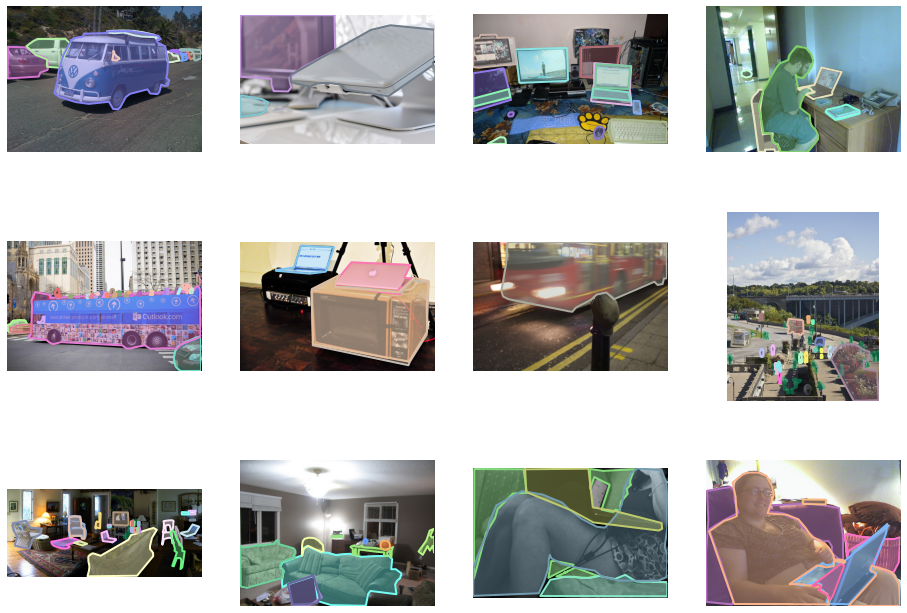

In [ ]:
fig = plt.figure(figsize=(16, 16))

for i, image_path in enumerate(next_image[0:12]):
    
    # to plot subplot 
    plot = plt.subplot(4, 4, i+1)
    plot.axis('Off')

    img_dict = coco.loadImgs(image_path)[0]
    # print(img_dict)
    img = io.imread(img_dict['coco_url'])
    plt.imshow(img)
    annotation_Ids = coco.getAnnIds(imgIds=img_dict['id'], catIds=category_IDs, iscrowd=None)
    # print(annotation_Ids)
    annotations = coco.loadAnns(annotation_Ids)
    # print(annotations)
    coco.showAnns(annotations)

plt.show()

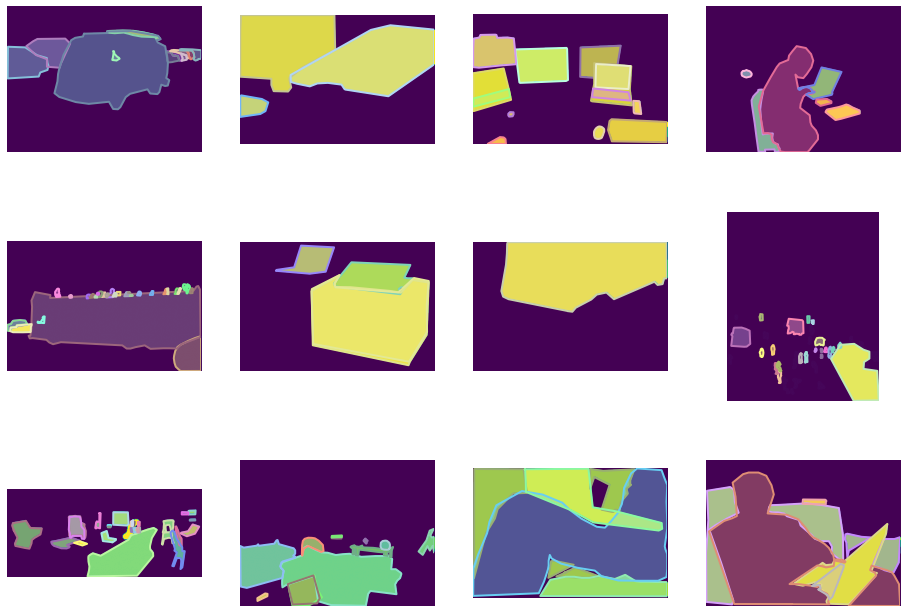

In [ ]:
fig = plt.figure(figsize=(16, 16))

for i, image_path in enumerate(next_image[0:12]):
    plot = plt.subplot(4, 4, i+1)
    plot.axis('Off')

    img_dict = coco.loadImgs(image_path)[0]
    img = io.imread(img_dict['coco_url'])
    plt.imshow(img)
    annotation_Ids = coco.getAnnIds(imgIds=img_dict['id'], catIds=category_IDs, iscrowd=None)
    annotations = coco.loadAnns(annotation_Ids)
    coco.showAnns(annotations)

    anns_img = np.zeros((img_dict['height'],img_dict['width']))
    
    for ann in annotations:
        anns_img = np.maximum(anns_img,coco.annToMask(ann)*ann['category_id'])
        plt.imshow(anns_img)

plt.show()

## Load images with keypoints Objects

In [ ]:
annotation_file = '/content/drive/MyDrive/annotations_trainval2017/annotations/person_keypoints_train2017.json'

coco_keypoint = COCO(annotation_file)

loading annotations into memory...
Done (t=8.32s)
creating index...
index created!


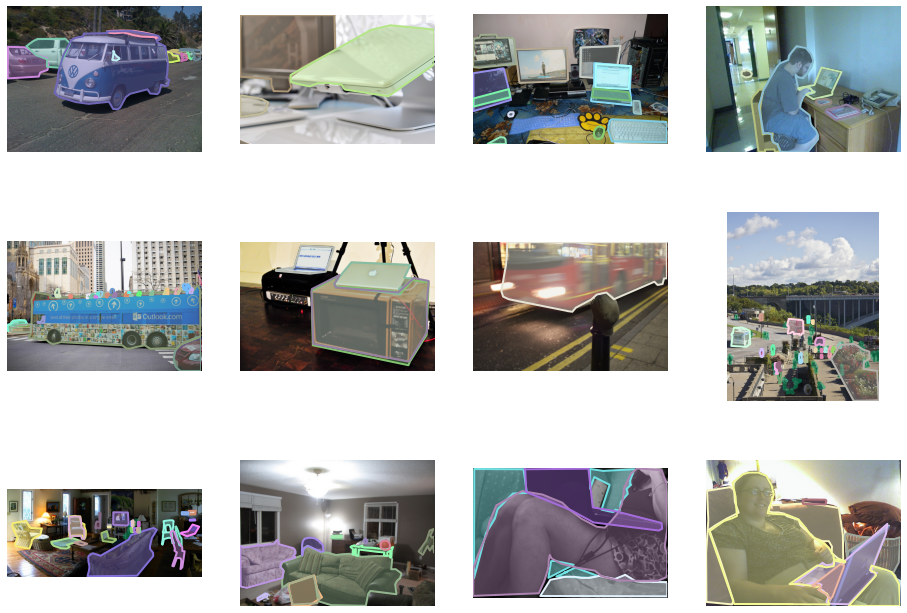

In [ ]:
plt.figure(figsize=(16, 16))

for i, image_path in enumerate(next_image[0:12]):

    # to plot subplot 
    plot = plt.subplot(4, 4, i+1)
    plot.axis('Off')

    img_dict = coco.loadImgs(image_path)[0]
    # print(img_dict)
    img = io.imread(img_dict['coco_url'])
    plt.imshow(img)
    annotation_Ids = coco.getAnnIds(imgIds=img_dict['id'], catIds=category_IDs, iscrowd=None)
    # print(annotation_Ids)
    annotations = coco.loadAnns(annotation_Ids)
    # print(annotations)
    coco.showAnns(annotations)

plt.show()

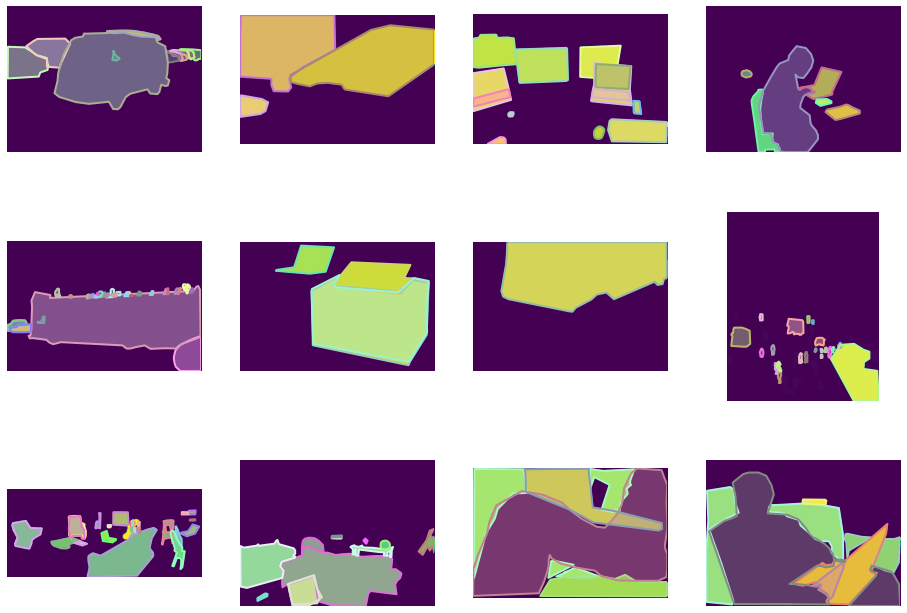

In [ ]:
fig = plt.figure(figsize=(16, 16))

for i, image_path in enumerate(next_image[0:12]):
    plot = plt.subplot(4, 4, i+1)
    plot.axis('Off')

    img_dict = coco.loadImgs(image_path)[0]
    img = io.imread(img_dict['coco_url'])
    plt.imshow(img)
    annotation_Ids = coco.getAnnIds(imgIds=img_dict['id'], catIds=category_IDs, iscrowd=None)
    annotations = coco.loadAnns(annotation_Ids)
    coco.showAnns(annotations)

    anns_img = np.zeros((img_dict['height'],img_dict['width']))
    
    for ann in annotations:
        anns_img = np.maximum(anns_img,coco.annToMask(ann)*ann['category_id'])
        plt.imshow(anns_img)

plt.show()

## Load images with respective captions

In [ ]:
caption_file = '/content/drive/MyDrive/annotations_trainval2017/annotations/captions_train2017.json'

coco_caption = COCO(caption_file)

loading annotations into memory...
Done (t=1.35s)
creating index...
index created!


A blue and white VW bus driving down a street.
A very nice looking old style van on the road.
An old van being drove in a parking lot with a surfboard on top of it. 
a mini van with a surfboard on top driving along a road 
a van with a surfboard on the roof is driving


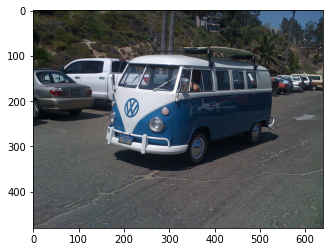

In [ ]:
image = coco.loadImgs(next_image[0])[0]
# print(image)
img = io.imread(image['coco_url'])
plt.imshow(img)
annotation_Id = coco_caption.getAnnIds(imgIds=image['id'])
# print(annotation_Id)
annotations = coco_caption.loadAnns(annotation_Id)
# print(annotations)

# to print the respected caption with their ID.
coco_caption.showAnns(annotations)
plt.show()

Man sitting at his desk looking at his open laptop.
A man sitting in front of a laptop computer.
A guy looks at his computer while sitting at his desk.
A man sitting in front of a laptop on a desk.
A young man is sitting at a desk and using a laptop.


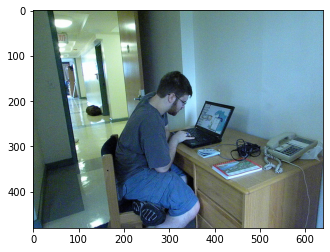

In [ ]:
image = coco.loadImgs(next_image[3])[0]
# print(image)
img = io.imread(image['coco_url'])
plt.imshow(img)
annotation_Id = coco_caption.getAnnIds(imgIds=image['id'])
# print(annotation_Id)
annotations = coco_caption.loadAnns(annotation_Id)
# print(annotations)

# to print the respected caption with their ID.
coco_caption.showAnns(annotations)
plt.show()

A living room with multiple couches and a bright overhead light. 
This living room is cluttered with things on the tables.  
A living room filled with furniture and two windows.
A very nice comfortable looking living room with a light on in the corner.
That is a really good looking space with all belongings.



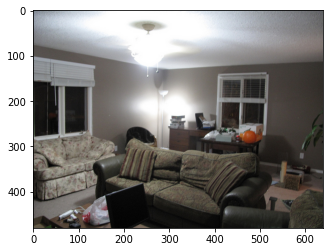

In [ ]:
image = coco.loadImgs(next_image[9])[0]
# print(image)
img = io.imread(image['coco_url'])
plt.imshow(img)
annotation_Id = coco_caption.getAnnIds(imgIds=image['id'])
# print(annotation_Id)
annotations = coco_caption.loadAnns(annotation_Id)
# print(annotations)

# to print the respected caption with their ID.
coco_caption.showAnns(annotations)
plt.show()

 * Here, I have taken "Bus" and "Laptop" images and captions only.

In [ ]:
print("Total images for training the data: ", len(image_Id))

Total images for training the data:  7470


# Prepare the Dataset

Group all the captions together having the same image and store them in dictionary. 

In [ ]:
dataset = dict()
image_captions = []

for img_id in image_Id:
    image = coco.loadImgs(img_id)[0]
    annotation_Ids = coco_caption.getAnnIds(imgIds = image['id'])
    annotations = coco_caption.loadAnns(annotation_Ids)
    image_captions = []
    for caption in annotations:

        # Remove Punctuation 
        caption = caption['caption'].translate(str.maketrans('','',string.punctuation))
        
        # Replace - to blank
        caption = caption.replace("-"," ")

        # Split string into list of words and convert each word into lowercase
        caption = caption.split()
        caption = [word.lower() for word in caption]

        # Join the word list into sentence and <start> and <end> tag to each sentence which helps
        # LSTM encoder - decoder model while training

        caption = "<start> " + " ".join(caption) + " <end>"
        image_captions.append(caption)

    dataset[image['coco_url']] = image_captions


print("Length of Dataset: ", len(dataset))

Length of Dataset:  7470


In [ ]:
dataset

{'http://images.cocodataset.org/train2017/000000096351.jpg': ['<start> a blue and white vw bus driving down a street <end>',
  '<start> a very nice looking old style van on the road <end>',
  '<start> an old van being drove in a parking lot with a surfboard on top of it <end>',
  '<start> a mini van with a surfboard on top driving along a road <end>',
  '<start> a van with a surfboard on the roof is driving <end>'],
 'http://images.cocodataset.org/train2017/000000366669.jpg': ['<start> an all white computer desk has silver equipment on it <end>',
  '<start> a table top and lap top computer sitting on top of a desk <end>',
  '<start> a desk with white computer equipment on it <end>',
  '<start> a laptop placed in a holder so it tilts comfortably <end>',
  '<start> a laptop on a desk fitted with a stand <end>'],
 'http://images.cocodataset.org/train2017/000000411277.jpg': ['<start> a desk with five different computers on a blue table cloth <end>',
  '<start> a table topped with laptop co

In [ ]:
dataset['http://images.cocodataset.org/train2017/000000097330.jpg']

['<start> a family sits in the living room all on laptops <end>',
 '<start> these people are sitting on a couching using their computers <end>',
 '<start> group of adults using laptop computers in living room <end>',
 '<start> people sitting on a couch all on computers <end>',
 '<start> a bunch of dudes that are on a couch <end>']

# Preprocess

## Tokenize the captions

In [ ]:
from itertools import chain

# flatten whole dictonary 
flatten_list = list(chain.from_iterable(dataset.values()))      # example = [[[1, 2, 3], [4, 5, 6]], [[7, 8, 9], [0, 1, 2]]] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2]
print(flatten_list[:5])

tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(flatten_list)
total_words = len(tokenizer.word_index) + 1

print("Length of the Vocabulary: ", total_words)

['<start> a blue and white vw bus driving down a street <end>', '<start> a very nice looking old style van on the road <end>', '<start> an old van being drove in a parking lot with a surfboard on top of it <end>', '<start> a mini van with a surfboard on top driving along a road <end>', '<start> a van with a surfboard on the roof is driving <end>']
Length of the Vocabulary:  7063


In [ ]:
tokenizer.word_index
print("Bus ID: ", tokenizer.word_index['bus'])
print("Laptop ID: ", tokenizer.word_index['laptop'])

Bus ID:  7
Laptop ID:  12


## Catching the features extracted from InceptionV3

* We are going to use inceptionV3 which is a pretrained model for image classification. We will extract features from last layers of convolution layer. This is also called a transfer learning.

* The Xception model was originally built for imagenet, we will do little changes for integrating with our model. Here, the Xception model takes 100 * 100 * 3 image size as input. We will remove the last classification layer and get the 2048 feature vector.

In [ ]:
model = Xception(include_top=False, pooling = 'avg')

image_features = {}

# This is just for one image

img = 'http://images.cocodataset.org/train2017/000000421813.jpg'
image = io.imread(img)
if image.ndim != 3:
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

# Resize each image size 299 * 299
image = cv2.resize(image, (299, 299))
image = np.expand_dims(image, axis=0)

# Normalize image pixels
image = image/127.5
image = image - 1.0     # for image range in -1 to 1

# Extract features from image
feature = model.predict(image)
# print(feature)
image_features[img] = feature
image_features

{'http://images.cocodataset.org/train2017/000000421813.jpg': array([[0.        , 0.02381118, 0.4342976 , ..., 0.00104059, 0.        ,
         0.29831576]], dtype=float32)}

In [ ]:
model = Xception(include_top=False, pooling = 'avg')

image_features = {}

for img in tqdm(dataset.keys()):
    image = io.imread(img)
    if image.ndim != 3:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Resize each image size 299 * 299
    image = cv2.resize(image, (299, 299))
    image = np.expand_dims(image, axis=0)

    # Normalize image pixels
    image = image/127.5
    image = image - 1.0     # for image range in -1 to 1

    # Extract features from image
    feature = model.predict(image)
    # print(feature)
    image_features[img] = feature

  0%|          | 0/7470 [00:00<?, ?it/s]

In [ ]:
print("Image features length: ", len(image_features))

Image features length:  7470


Here, I have found the max_length among the captions which will help to pad each caption with same length.

In [ ]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(i) for i in descriptions[key]]
    return all_desc

def max_len(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(i.split()) for i in desc_list)

max_length = max_len(dataset)
max_length 

46

# Make a Data Generator

* We have to train our model on 7470 images and each image will contain 2048 length feature vector and caption is also represented as numbers. This amount of data for 7470 images is not possible to hold into memory so we will be using a generator method that will be using a generator method that will yield batches.

* The generator will yield the input and output sequence.


For example:
The input to our model is [x1, x2] and the output will be y, where x1 is the 2048 feature vector of that image, x2 is the input text sequence and y is the output text sequence that the model has to predict.

In [ ]:
# create input-output sequence pairs from the image description.

def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield([input_image, input_sequence], output_word)

def create_sequences(tokenizer, max_length, desc_list, feature):
    x1, x2, y = [], [], []

    # walk through each description for the image
    for desc in desc_list:

        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]

        # split one sequence into multiple X, y, pairs
        for i in range(1, len(seq)):

            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            
            # pad input sequence 
            in_seq = pad_sequences([in_seq], maxlen = max_length)[0]

            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes = total_words)[0]

            # store
            x1.append(feature)      # image feature
            x2.append(in_seq)       # Caption input
            y.append(out_seq)       # Caption output

    return np.array(x1), np.array(x2), np.array(y)

# Define CNN - LSTM Model

In [ ]:
# Define the model

def define_model(total_words, max_length):

    # features from CNN model squeezed from 2048 to 256 nodes
    inputs_1 = Input(shape=(2048,))
    feature_1 = Dropout(0.5)(inputs_1)
    feature_2 = Dense(256, activation='relu')(feature_1)

    # LSTM sequence model
    inputs_2 = Input(shape=(max_length,))
    sequence_1 = Embedding(total_words, 256, mask_zero = True)(inputs_2)
    sequence_2 = Dropout(0.5)(sequence_1)
    sequence_3 = LSTM(256)(sequence_2)

    # Merging both models
    decoder_1 = add([feature_2, sequence_3])
    decoder_2 = Dense(256, activation='relu')(decoder_1)
    outputs = Dense(total_words, activation='softmax')(decoder_2)

    # tie it together [image, seq] [word]
    model = Model(inputs = [inputs_1, inputs_2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    
    return model

In [ ]:
# train our model

print('Dataset: ', len(dataset))
print('Descriptons: train = ', len(dataset))
print('Photos: train = ', len(image_features))
print('Vocabulary Size : ', total_words)
print('Description Length : ', max_length)

model = define_model(total_words=total_words, max_length=max_length)
epochs = 1
steps = len(dataset)

# making a directory models to save our models

import os
# os.mkdir('model')

for i in range(epochs):
    generator = data_generator(dataset, image_features, tokenizer, max_length)
    model.fit(generator, epochs=5, steps_per_epoch=steps, verbose=1)
    model.save('/content/drive/MyDrive/model/model_' + str(i) + ".h5")

Dataset:  7470
Descriptons: train =  7470
Photos: train =  7470
Vocabulary Size :  7063
Description Length :  46
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 46)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 46, 256)      1808128     ['input_6[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_5[0][

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except:
        print("ERROR: Couldn't open image..! Make sure the image path and extension is correct")

    image = image.resize((299,299))
    image = np.array(image)

    # for images that has 4 channels, we convert them into 3 channels
    if image.shape[2] == 4:
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image / 127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'

    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen= max_length)
        pred = model.predict([photo, sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)

        if word is None:
            break
        in_text += ' ' + word

        if word == 'end':
            break
    return in_text

# max_length = 46

model = load_model('/content/drive/MyDrive/model/model_0.h5')
xception_model = Xception(include_top=False, pooling='avg')


In [ ]:
img_paths = ["/content/drive/MyDrive/val2017/val2017/000000001503.jpg",
            "/content/drive/MyDrive/val2017/val2017/000000005037.jpg",
            "/content/drive/MyDrive/val2017/val2017/000000009400.jpg",
            "/content/drive/MyDrive/val2017/val2017/000000011149.jpg",
            "/content/drive/MyDrive/val2017/val2017/000000012670.jpg"]




start a desk with a laptop and a keyboard and a mouse end


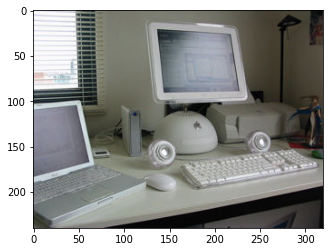

In [ ]:
photo = extract_features(img_paths[0], xception_model)
img = Image.open(img_paths[0])
description = generate_desc(model, tokenizer, photo, max_length)
print('\n\n')
print(description)
plt.imshow(img)




start a bus is parked in front of a building end


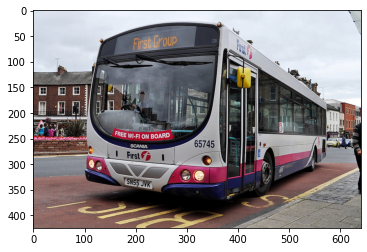

In [ ]:
photo = extract_features(img_paths[1], xception_model)
img = Image.open(img_paths[1])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)




start a man sitting at a table with a laptop end


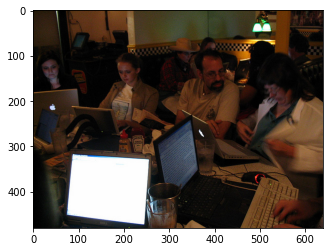

In [ ]:
photo = extract_features(img_paths[2], xception_model)
img = Image.open(img_paths[2])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)




start a man riding a bike down a street end


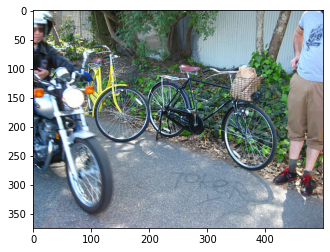

In [ ]:
photo = extract_features(img_paths[3], xception_model)
img = Image.open(img_paths[3])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)




start a group of people are standing in a parking lot end


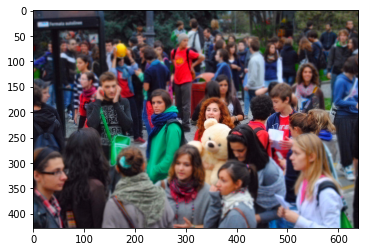

In [ ]:
Tphoto = extract_features(img_paths[4], xception_model)
img = Image.open(img_paths[4])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)